In [1]:
import pyemma
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
import numpy as np
from glob import glob
import scipy

In [2]:
scores = [
np.load('scores_msmlag10ns_splittica_alleigen.npy'),
np.load('50ns/scores_msmlag50ns_splittica_alleigen.npy'),
np.load('100ns/scores_msmlag100ns_splittica_alleigen.npy')
]

In [3]:
def get_order_lag(no_eigenvalues, lag):
    
    current_choice = no_eigenvalues  # number of eigenvalues

    # lag is 0, 1 or 2 meaning 10ns, 50ns, 100ns
    
    output = scores[lag]
    
    #output = scores
    eigenvalues_no = 49 # how many numbers of eigenvalues we've tried
    eigenvalues_index = current_choice - 2 # this is actual number of eigenvalues - 2

    # test scores

    y_kinetic = []
    y_commute = []
    tic_nos_kinetic = []
    tic_nos_commute = []

    for model in output[1]:
        y_kinetic_ = []
        y_commute_ = []
        tic_nos_kinetic_ = []
        tic_nos_commute_ = []
        if isinstance(model[0], list):
            for replicate in model[eigenvalues_index::eigenvalues_no]:
                y_kinetic_.append(replicate[0][0])
                y_commute_.append(replicate[0][1])
                tic_nos_kinetic_.append(replicate[1][0])
                tic_nos_commute_.append(replicate[1][1])
        else:
            for replicate in model[eigenvalues_index::eigenvalues_no]:
                y_kinetic_.append(replicate[0])
                y_commute_.append(replicate[1])
        y_kinetic.append(np.array(y_kinetic_))
        y_commute.append(np.array(y_commute_))
        if tic_nos_kinetic_:
            tic_nos_kinetic.append(np.max(tic_nos_kinetic_))
        else:
            tic_nos_kinetic.append(None)
        if tic_nos_commute_:
            tic_nos_commute.append(np.max(tic_nos_commute_))
        else:
            tic_nos_commute.append(None)

    y = y_kinetic + y_commute

    x = []

    for index, model in enumerate(output[0]):
        if tic_nos_kinetic[index]:
            x.append(str(('kinetic', model[0], str(model[1]) + ': ' + str(tic_nos_kinetic[index]), model[2], model[3])))
        else:
            x.append(str(('kinetic', model[0], model[1], model[2], model[3])))
    for index, model in enumerate(output[0]):
        if tic_nos_commute[index]:
            x.append(str(('commute', model[0], str(model[1]) + ': ' + str(tic_nos_commute[index]), model[2], model[3])))
        else:
            x.append(str(('commute', model[0], model[1], model[2], model[3])))

    order_means = []
    #just_means = []
    for index, model in enumerate(x):
        order_means.append((model, np.mean(y[index])))
        #just_means.append(np.mean(y[index]))
    order_means = sorted(order_means, key = lambda i: i[1], reverse=True)
    order = [i[0] for i in order_means]
    
#     # for those with 95p tics, remove the number of tics, so the labels between two nos of eigen are the same
#     order_ = []
#     for model in order:
#         split = model.split(', ')
#         if split[2][:4] == "'95p":
#             new_model = split[0] + ", " + split[1] + ", " + split[2][:4] + "', " + split[3] + ")"
#             order_.append(new_model)
#         else:
#             new_model = split[0] + ", " + split[1] + ", " + split[2] + ", " + split[3] + ")"
#             order_.append(new_model)
            
    
#     return order_


    # for those with 95p tics, remove the 95p so we can read number of tics into MSM making script
    order_ = []
    for model in order:
        split = model.split(', ')
        if split[2][:4] == "'95p":
            new_model = split[0] + ", " + split[1] + ", " + split[2][6:-1] + ", " + split[3] + ")"
            order_.append(new_model)
        else:
            new_model = split[0] + ", " + split[1] + ", " + split[2] + ", " + split[3] + ")"
            order_.append(new_model)
    
    return order_

In [4]:
top_models = []

eigenvalues = [2,5,10,20,30,40,50]

for k in range(len(eigenvalues)):
    for j in range(3):
        top_models.append(get_order_lag(eigenvalues[k], j)[0])

In [5]:
set(top_models)

{"('commute', 1, 10, 100)",
 "('commute', 1, 10, 50)",
 "('commute', 1, 100, 200)",
 "('commute', 1, 2, 200)",
 "('commute', 1, 50, 100)",
 "('commute', 1, 50, 200)",
 "('kinetic', 1, 10, 100)",
 "('kinetic', 1, 10, 50)",
 "('kinetic', 1, 100, 100)",
 "('kinetic', 1, 100, 200)",
 "('kinetic', 1, 150, 100)",
 "('kinetic', 1, 150, 200)",
 "('kinetic', 1, 50, 100)",
 "('kinetic', 1, 50, 400)"}

In [6]:
len(top_models)

21

In [7]:
len(set(top_models))

14

In [8]:
# back here having results from lilac

In [9]:
set_top_dtrajs = np.load('top_models/dtrajs_top_models.npy')

In [10]:
# at lag time 100 ns

In [11]:
set_top_msms = []

for dtraj in set_top_dtrajs:
    #msm = pyemma.msm.bayesian_markov_model(list(dtraj), 500)
    msm = pyemma.msm.estimate_markov_model(list(dtraj), 500)
    set_top_msms.append(msm)

In [12]:
len(set_top_msms)

14

In [13]:
top_models_dict = dict()

for i in range(len(top_models)):
    model = top_models[i]
    for j in range(len(set(top_models))):
        if list(set(top_models))[j] == model:
            top_models_dict[i] = j

In [14]:
lag_eigen_matrix = np.zeros((7,3))

counter = 0
for i in range(7):
    for j in range(3):
        lag_eigen_matrix[i,j] = set_top_msms[top_models_dict[counter]].timescales()[0]*0.2 # in ns
        counter += 1

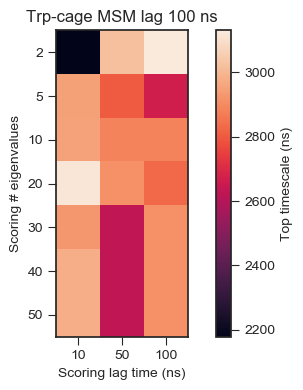

In [19]:
plt.figure(dpi=100)
plt.imshow(lag_eigen_matrix)
cb = plt.colorbar()
plt.xlabel('Scoring lag time (ns)')
plt.ylabel('Scoring # eigenvalues')
plt.xticks(range(3), [10,50,100])
plt.yticks(range(7), [2,5,10,20,30,40,50])
cb.set_label('Top timescale (ns)')
plt.title('Trp-cage MSM lag 100 ns')
plt.tight_layout()
plt.savefig('top_models/trpcage_lag100ns_lag_eigen_its_heatmap_top_its.png', dpi=300)
plt.savefig('top_models/trpcage_lag100ns_lag_eigen_its_heatmap_top_its.pdf')
plt.show()

In [16]:
lag_eigen_matrix_all = np.zeros((7,3))

counter = 0
for i in range(7):
    for j in range(3):
        lag_eigen_matrix_all[i,j] = np.sum([x for x in set_top_msms[top_models_dict[counter]].timescales()*0.2 if x > 50]) # in ns
        counter += 1

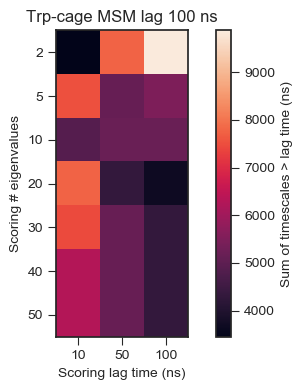

In [18]:
plt.figure(dpi=100)
plt.imshow(lag_eigen_matrix_all)
cb = plt.colorbar()
plt.xlabel('Scoring lag time (ns)')
plt.ylabel('Scoring # eigenvalues')
plt.xticks(range(3), [10,50,100])
plt.yticks(range(7), [2,5,10,20,30,40,50])
cb.set_label('Sum of timescales > lag time (ns)')
plt.title('Trp-cage MSM lag 100 ns')
plt.tight_layout()
plt.savefig('top_models/trpcage_lag100ns_lag_eigen_its_heatmap_all_nondecay_its.png', dpi=300)
plt.savefig('top_models/trpcage_lag100ns_lag_eigen_its_heatmap_all_nondecay_its.pdf')
plt.show()